# Working with FITS images

In this example we will be working with `.fits` images to achieve the following:

+ read in image data
+ apply a normalization and stretch to the image
+ save the raw image as a `.png`
+ plot the image with coordinate grid and labels
+ align mulitiple `.fits` images
+ create a false color image

## Packages being used
We will be makeing use of the following packages:

+ `astropy`: most of the heavy lifting is done here
+ `matplotlib`: all of the plotting is done here
+ `reproject`: aligns image data based on `.fits` headers
+ `numpy`: making arrays

## Relevant documentation
Useful documentation:

+ `astropy`: http://docs.astropy.org/en/stable/wcs/, http://docs.astropy.org/en/stable/visualization/normalization.html, http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html
+ `matplotlib`: http://matplotlib.org/3.1.1/api/pyplot_summary.html
+ `reproject`: http://reproject.readthedocs.io/en/stable/

In [10]:
from astropy.visualization import stretch, interval, mpl_normalize
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter
import numpy as np
import mpl_style
%matplotlib inline
plt.style.use('default')
plt.style.use(mpl_style.style1)

### Read in the file
Read in the B-band `.fits` file, pull out the wcs information from the header, and get the image data:

In [4]:
hdu_b = fits.open('M31_SAsb_b.fits')
w = WCS(hdu_b[0].header)
image_b = hdu_b[0].data

 [astropy.io.fits.verify]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
Changed DATE-OBS from '1987/09/20        ' to '1987-09-20T00:00:00.0''. [astropy.wcs.wcs]


You will see warnings from the wcs line saying that the header info being depreciated, these are old `.fits` files (DSS data) and you can safely ignore this.

### Normalize and scale the image
To convert the raw pixel counts into an image we first need to normalize the image and than apply a stretch.  For this galaxy we are going to set the normalization so the lowest 10% of pixels are `0` and the top 0.05% of pixels are `1` before applying a `log` stretch to the image.  Since we will be applying this same code to the R- and IR-band images as well we will write this as a function.

In [5]:
def logScaleImage(image, return_full=False):
    # create the normalization function
    reagon = interval.AsymmetricPercentileInterval(10., 99.95)
    # pull out the min and max vales for this normalization
    vmin, vmax = reagon.get_limits(image)
    # define the `a` value for the log stretch in terms of these limits
    a = vmax/vmin - 1
    # create the stretching function
    scale = stretch.LogStretch(a=a)
    # compose the two functions and apply it to the image
    image_scaled = (scale + reagon)(image)
    if return_full:
        # if `return_full` flag is set return normlaization and stretch info as well
        return image_scaled, vmin, vmax, scale
    # return the final normalized and stretched image
    return image_scaled

Ignore the `return_full` flag for now, we will come back to why that information is useful later on.  Now we can use this function to process our image:

In [6]:
image_b_scaled, vmin, vmax, scale = logScaleImage(image_b, return_full=True)

### Save the image
We can directly save the resulting (full size) image to a `.png` using `plt.imsave`.  Since this is a single band image we will use a gray scale colormap, and to keep the proper orientation of the image we will set `origin='lower'`:

In [7]:
plt.imsave('image_output/M31_b.png', image_b_scaled, cmap='Greys_r', origin='lower')

### Making a publication ready plot
This is helpful if you just want to extract the image from a `.fits` file, but if you are creating a figure for a paper you will want to add axes and labels to the image as well.  The heavy lifting adding axis information is taken care of by the `wcsaxes` package that extends `matplotlib`'s projection system to understand wcs.  We will be applying these settings to two different plots, so we will write this bit as a function:

In [8]:
def set_up_axes(ax):
    # extract the coordinates from the axes object
    ra = ax.coords['ra']
    dec = ax.coords['dec']
    # add axis labels
    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    # add a coordinate grid to the image
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid', lw=1.5)
    for coord in [ra, dec]:
        # set the tick formats
        coord.set_major_formatter('d.dd')
        coord.set_ticks(color='white')
        coord.display_minor_ticks(True)

With this set up we now have to create our figure and axes than plot our image:

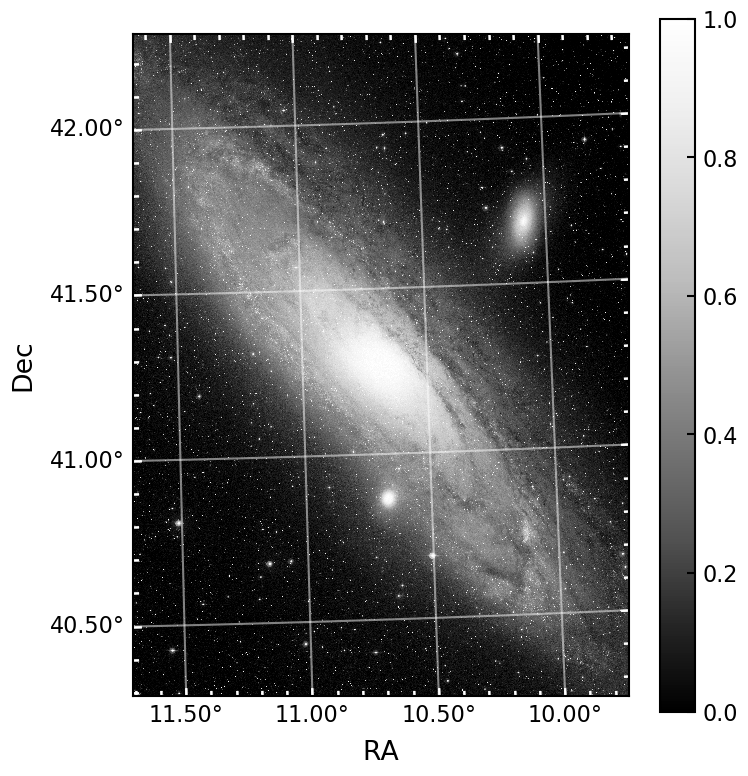

In [11]:
fig1 = plt.figure(1, figsize=(8, 9))
# create an axes with a wcs projection
ax = fig1.add_subplot(111, projection=w)
set_up_axes(ax)
plt.imshow(image_b_scaled, cmap='Greys_r')
plt.colorbar();

### Making the colorbar mean something
Notice how the colorbar extends from `0` to `1` in the final plot, this is a result of our normalization, and is not that useful for a publication figure.  To get around this we can instead create a normalization function that is passed into `plt.imshow` and use the original image:

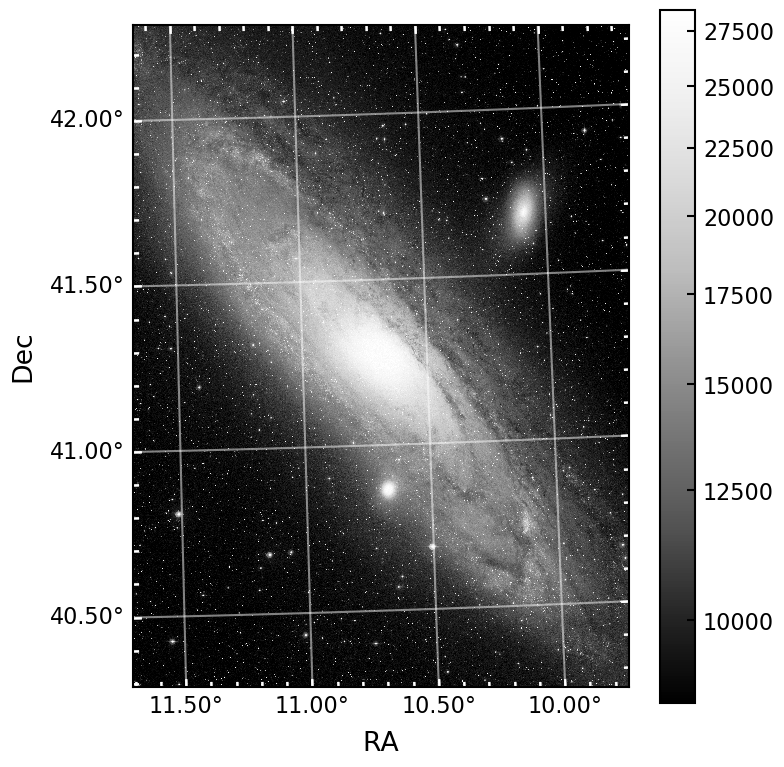

In [13]:
# create and normalization function matplotlib can use
# this is what the `return_full` flag was for
norm = mpl_normalize.ImageNormalize(vmin=vmin, vmax=vmax, stretch=scale)
fig2 = plt.figure(2, figsize=(8, 9))
ax2 = fig2.add_subplot(111, projection=w)
set_up_axes(ax2)
plt.imshow(image_b, cmap='Greys_r', norm=norm)
plt.colorbar();

Now the colorbar provides the pixel values instead of the normalized values!

### Making a false color image
Now that we know how to make single band images, let make a false color RGB image using the B-, R-, and IR-bands.  Since the other bands were take at different times, the raw images are not likely to line up pixel-by-pixel, instead we will have to use the wcs information from the header to reproject the R- and IR-bands onto the same grid as the B-band.  This will be done using the `reproject` package:

In [14]:
hdu_r = fits.open('M31_SAsb_r.fits')
hdu_ir = fits.open('M31_SAsb_ir.fits')

image_r, footprint_r = reproject_interp(hdu_r[0], hdu_b[0].header)
image_ir, footprint_ir = reproject_interp(hdu_ir[0], hdu_b[0].header)

 [astropy.io.fits.verify]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
Changed DATE-OBS from '1986/11/28        ' to '1986-11-28T00:00:00.0''. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
Changed DATE-OBS from '1987/09/20        ' to '1987-09-20T00:00:00.0''. [astropy.wcs.wcs]
/Users/coleman/anaconda3/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to 

Again you will get warnings about out dated `.fits` headers, but you can ignore these.  Now that the images have been reprojected we can apply the log stretch to each band:

In [15]:
image_r_scaled = logScaleImage(image_r)
image_ir_scaled = logScaleImage(image_ir)

The last thing to do is stack the 3 images into a single array and pass it into `imsave`:

In [16]:
RGB_image = np.zeros([image_b_scaled.shape[0], image_b_scaled.shape[1], 3])
# R image
RGB_image[:, :, 0] = image_ir_scaled
# G image
RGB_image[:, :, 1] = image_r_scaled
# B image
RGB_image[:, :, 2] = image_b_scaled
# make sure NaN values are set to zero
RGB_image[~np.isfinite(RGB_image)] = 0.0
plt.imsave('image_output/M31_rgb.png', RGB_image)

You can also pass this array into `plt.imshow` to as above and place coordinates on it.

### Picking the colors
If you don't want your three bands to be red, green, and blue (or if you don't have exactly three bands to begin with), you can specify the colors for each band and combine them together.  Here is an example function that does this:

In [17]:
cc = ColorConverter()

def colorize(*args, colors=[]):
    assert len(args) == len(colors), 'You need to prvide the same number of colors as images'
    images = []
    for img, color in zip(args, colors):
        # convert colors to an rgb tuple, then reshape it to be 3x1x1 array
        # colors can be in any format maplotlib understands
        rgb = np.array(cc.to_rgb(color)).reshape(3, 1, 1)
        # set NaNs to 0
        img[~np.isfinite(img)] = 0.0
        # mulitiply the color by the image, resulting shape is 3xNxM
        images.append(rgb * img)
    base = images[0]
    # screen each layer together
    for layer in images[1:]:
        base = 1 - ((1 - base) * (1 - layer))
    # reshpae into an RGB array of shape NxMx3
    return np.rollaxis(base, 0, 3)

Let's use this function to create a YCM version of our image:

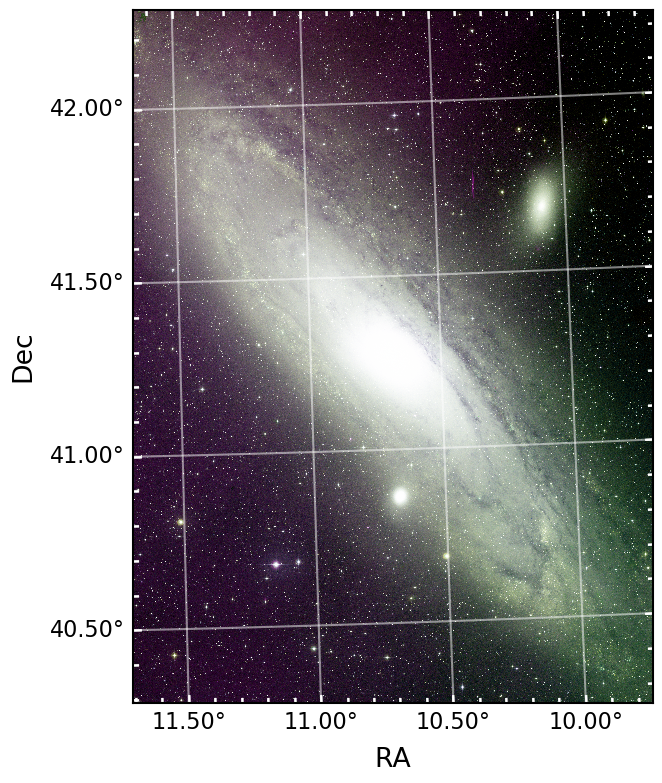

In [19]:
YCM = colorize(image_b_scaled, image_r_scaled, image_ir_scaled, colors=['#ffff00', '#00ffff', '#ff00ff'])

fig3 = plt.figure(3, figsize=(7, 9))
# create an axes with a wcs projection
ax = fig3.add_subplot(111, projection=w)
set_up_axes(ax)
plt.imshow(YCM);